In [25]:
# run in training specialist
import json
with open("artifacts/label2idx.json") as f:
    label2idx = json.load(f)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_specialist(model, train_loader, val_loader, num_epochs=5, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        for x, y, _ in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} train loss: {total_loss/len(train_loader):.4f}")

        # ---- Validation ----
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x, y, _ in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred = logits.argmax(dim=1).cpu().numpy()
                preds.extend(pred)
                gts.extend(y.cpu().numpy())
        f1 = f1_score(gts, preds, average="macro")
        print(f"Epoch {epoch} val macro-F1: {f1:.4f}")

    return model

In [41]:
import json
import torch
import pandas as pd
import numpy as np
import librosa
from datasets import AudioDataset
from sklearn.preprocessing import StandardScaler
import joblib
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Load label mapping
with open("artifacts/label2idx.json") as f:
    label2idx = json.load(f)

print(f"Labels: {list(label2idx.keys())}")

# ==========================
# ROBUST Feature Extraction Function
# ==========================
def extract_audio_features_robust(wav_tensor, sr=16000):
    """Extract exactly 106 features with bulletproof error handling"""
    try:
        # Convert tensor to numpy for librosa processing
        y = wav_tensor.numpy() if isinstance(wav_tensor, torch.Tensor) else wav_tensor
        
        # Ensure minimum length for stable feature extraction
        if len(y) < 1600:  # 0.1 seconds at 16kHz
            y = np.pad(y, (0, 1600 - len(y)))
        
        features = []

        # === Time Domain Features (3) ===
        try:
            zcr_val = librosa.feature.zero_crossing_rate(y)
            zcr = float(np.mean(zcr_val))
            
            rmse_val = librosa.feature.rms(y=y)
            rmse = float(np.mean(rmse_val))
            
            try:
                tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=512)
                tempo = float(tempo) if not np.isnan(tempo) else 120.0
            except:
                tempo = 120.0
                
            features.extend([zcr, rmse, tempo])
        except Exception as e:
            features.extend([0.1, 0.1, 120.0])

        # === Spectral Features (5) ===
        try:
            spec_centroid_val = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_centroid = float(np.mean(spec_centroid_val))
            
            spec_bw_val = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            spec_bw = float(np.mean(spec_bw_val))
            
            spec_contrast_val = librosa.feature.spectral_contrast(y=y, sr=sr)
            spec_contrast = float(np.mean(spec_contrast_val))
            
            rolloff_val = librosa.feature.spectral_rolloff(y=y, sr=sr)
            rolloff = float(np.mean(rolloff_val))
            
            spec_flatness_val = librosa.feature.spectral_flatness(y=y)
            spec_flatness = float(np.mean(spec_flatness_val))
            
            features.extend([spec_centroid, spec_bw, spec_contrast, rolloff, spec_flatness])
        except Exception as e:
            features.extend([1000.0, 1000.0, 0.5, 4000.0, 0.1])

        # === MFCC Features (60: 20+20+20) ===
        try:
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
            mfcc_mean = np.mean(mfcc, axis=1)
            mfcc_std = np.std(mfcc, axis=1)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
            
            # Convert to lists of floats
            mfcc_mean_list = [float(x) for x in mfcc_mean[:20]]
            mfcc_std_list = [float(x) for x in mfcc_std[:20]]
            mfcc_delta_list = [float(x) for x in mfcc_delta_mean[:20]]
            
            features.extend(mfcc_mean_list)
            features.extend(mfcc_std_list)
            features.extend(mfcc_delta_list)
        except Exception as e:
            features.extend([0.0] * 60)

        # === Chroma Features (24: 12+12) ===
        try:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            chroma_mean = np.mean(chroma, axis=1)
            chroma_std = np.std(chroma, axis=1)
            
            chroma_mean_list = [float(x) for x in chroma_mean[:12]]
            chroma_std_list = [float(x) for x in chroma_std[:12]]
            
            features.extend(chroma_mean_list)
            features.extend(chroma_std_list)
        except Exception as e:
            features.extend([0.0] * 24)

        # === Tonnetz Features (12: 6+6) ===
        try:
            y_harmonic = librosa.effects.harmonic(y)
            tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
            tonnetz_mean = np.mean(tonnetz, axis=1)
            tonnetz_std = np.std(tonnetz, axis=1)
            
            tonnetz_mean_list = [float(x) for x in tonnetz_mean[:6]]
            tonnetz_std_list = [float(x) for x in tonnetz_std[:6]]
            
            features.extend(tonnetz_mean_list)
            features.extend(tonnetz_std_list)
        except Exception as e:
            features.extend([0.0] * 12)

        # === Additional Polynomial Features (2) ===
        try:
            poly_features = librosa.feature.poly_features(y=y, sr=sr, order=1)
            poly_mean = np.mean(poly_features, axis=1)
            poly_list = [float(x) for x in poly_mean[:2]]
            features.extend(poly_list)
        except Exception as e:
            features.extend([0.0, 0.0])

        # Final validation and cleaning
        clean_features = []
        for feat in features:
            if isinstance(feat, (int, float)) and not (np.isnan(feat) or np.isinf(feat)):
                clean_features.append(float(feat))
            else:
                clean_features.append(0.0)

        # Ensure exactly 106 features
        while len(clean_features) < 106:
            clean_features.append(0.0)
        clean_features = clean_features[:106]

        return np.array(clean_features, dtype=np.float32)
    
    except Exception as e:
        print(f"Critical error in feature extraction: {e}")
        return np.zeros(106, dtype=np.float32)

# ==========================
# Enhanced Dataset Processing
# ==========================
def extract_features_from_dataset(dataset, dataset_name="dataset"):
    """Extract features from AudioDataset with comprehensive error handling"""
    print(f"\n🎵 Processing {dataset_name} ({len(dataset)} samples)")
    
    features_list = []
    labels_list = []
    metadata_list = []
    
    error_count = 0
    
    # Process with progress bar
    for idx in tqdm(range(len(dataset)), desc=f"Extracting {dataset_name}"):
        try:
            wav_tensor, label, metadata = dataset[idx]
            features = extract_audio_features_robust(wav_tensor, sr=dataset.sr)
            
            # Verify feature is correct shape and type
            if not isinstance(features, np.ndarray) or features.shape != (106,):
                error_count += 1
                features = np.zeros(106, dtype=np.float32)
            
            features_list.append(features)
            labels_list.append(int(label))
            metadata_list.append(metadata)
            
        except Exception as e:
            error_count += 1
            if error_count <= 5:  # Only print first 5 errors
                print(f"❌ Error sample {idx}: {e}")
            
            # Add fallback data for failed samples
            features_list.append(np.zeros(106, dtype=np.float32))
            labels_list.append(0)
            metadata_list.append({"video_id": "error", "window_idx": idx})
    
    if error_count > 0:
        print(f"⚠️  Total errors: {error_count}/{len(dataset)} samples ({error_count/len(dataset)*100:.1f}%)")
    
    # Convert to numpy arrays safely
    try:
        # Stack features manually to avoid shape issues
        X = np.zeros((len(features_list), 106), dtype=np.float32)
        for i, feat in enumerate(features_list):
            X[i] = feat
        
        y = np.array(labels_list, dtype=np.int64)
        
        print(f"✅ Final arrays: X={X.shape}, y={y.shape}")
        return X, y, metadata_list
        
    except Exception as e:
        print(f"❌ Critical error in array conversion: {e}")
        # Emergency fallback
        X = np.zeros((len(features_list), 106), dtype=np.float32)
        y = np.zeros(len(features_list), dtype=np.int64)
        return X, y, metadata_list

# ==========================
# Main Extraction Function
# ==========================
def main():
    print("🎵 AUDIO FEATURE EXTRACTION (Robust Version)")
    print("="*60)
    
    # Create output directory
    output_dir = "D:/Satria_Data/models/specialists/audio"
    os.makedirs(output_dir, exist_ok=True)
    
    # Create datasets
    try:
        train_dataset = AudioDataset(
            manifest_csv="artifacts/train_manifest_all.csv",
            split="train",
            fold=0,
            sr=16000,
            label2idx=label2idx
        )
        
        val_dataset = AudioDataset(
            manifest_csv="artifacts/val_manifest_all.csv", 
            split="test",
            fold=0,
            sr=16000,
            label2idx=label2idx
        )
        
        print(f"📂 Train dataset: {len(train_dataset)} samples")
        print(f"📂 Validation dataset: {len(val_dataset)} samples")
        
    except Exception as e:
        print(f"❌ Error loading datasets: {e}")
        return None, None, None, None
    
    # Extract features from both training and validation
    X_train, y_train, train_metadata = extract_features_from_dataset(train_dataset, "Training")
    X_val, y_val, val_metadata = extract_features_from_dataset(val_dataset, "Validation")
    
    print(f"\n📊 Results:")
    print(f"Training features shape: {X_train.shape}")
    print(f"Validation features shape: {X_val.shape}")
    print(f"Feature dimension: {X_train.shape[1]}")
    
    # Enhanced data quality check
    print(f"\n🔍 Data quality check:")
    print(f"Train - NaN: {np.isnan(X_train).sum()}, Inf: {np.isinf(X_train).sum()}")
    print(f"Val - NaN: {np.isnan(X_val).sum()}, Inf: {np.isinf(X_val).sum()}")
    print(f"Train - Min: {X_train.min():.3f}, Max: {X_train.max():.3f}")
    print(f"Val - Min: {X_val.min():.3f}, Max: {X_val.max():.3f}")
    
    # Clean data (redundant but safe)
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Save raw features
    print(f"\n💾 Saving features...")
    try:
        np.save(f"{output_dir}/X_train_raw.npy", X_train)
        np.save(f"{output_dir}/y_train.npy", y_train)
        np.save(f"{output_dir}/X_val_raw.npy", X_val)
        np.save(f"{output_dir}/y_val.npy", y_val)
        
        # Save feature info
        feature_info = {
            'feature_dim': X_train.shape[1],
            'num_classes': len(label2idx),
            'label2idx': label2idx,
            'train_samples': X_train.shape[0],
            'val_samples': X_val.shape[0],
            'feature_extraction_method': 'librosa_106_features_robust',
            'robust_error_handling': True
        }
        
        with open(f"{output_dir}/feature_info.json", 'w') as f:
            json.dump(feature_info, f, indent=2)
        
        print(f"✅ Successfully saved:")
        print(f"  - {output_dir}/X_train_raw.npy")
        print(f"  - {output_dir}/y_train.npy")
        print(f"  - {output_dir}/X_val_raw.npy") 
        print(f"  - {output_dir}/y_val.npy")
        print(f"  - {output_dir}/feature_info.json")
        
    except Exception as e:
        print(f"❌ Error saving files: {e}")
        return X_train, X_val, y_train, y_val
    
    # Show label distribution
    print(f"\n📊 Label Distribution:")
    idx2label = {v: k for k, v in label2idx.items()}
    
    print("Training set:")
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    for label_idx, count in zip(unique_train, counts_train):
        label_name = idx2label.get(label_idx, f"Unknown_{label_idx}")
        print(f"  {label_name}: {count} samples")
    
    print("Validation set:")
    unique_val, counts_val = np.unique(y_val, return_counts=True)
    for label_idx, count in zip(unique_val, counts_val):
        label_name = idx2label.get(label_idx, f"Unknown_{label_idx}")
        print(f"  {label_name}: {count} samples")
    
    print(f"\n🎉 Feature extraction completed successfully!")
    print(f"📈 Ready for model training with {X_train.shape[1]} features per sample")
    
    return X_train, X_val, y_train, y_val

# ==========================
# Training Function
# ==========================
def train_specialist(model, train_loader, val_loader, num_epochs=5, lr=1e-4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        for x, y, _ in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} train loss: {total_loss/len(train_loader):.4f}")

        # ---- Validation ----
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x, y, _ in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred = logits.argmax(dim=1).cpu().numpy()
                preds.extend(pred)
                gts.extend(y.cpu().numpy())
        f1 = f1_score(gts, preds, average="macro")
        print(f"Epoch {epoch} val macro-F1: {f1:.4f}")

    return model

# ==========================
# Run
# ==========================
if __name__ == "__main__":
    X_train, X_val, y_train, y_val = main()

Labels: ['Anger', 'Fear', 'Joy', 'Neutral', 'Proud', 'Sadness', 'Surprise', 'Trust']
🎵 AUDIO FEATURE EXTRACTION (Robust Version)
📂 Train dataset: 69778 samples
📂 Validation dataset: 12180 samples

🎵 Processing Training (69778 samples)


Extracting Training: 100%|██████████| 69778/69778 [1:43:09<00:00, 11.27it/s]


✅ Final arrays: X=(69778, 106), y=(69778,)

🎵 Processing Validation (12180 samples)


Extracting Validation: 100%|██████████| 12180/12180 [19:17<00:00, 10.52it/s]


✅ Final arrays: X=(12180, 106), y=(12180,)

📊 Results:
Training features shape: (69778, 106)
Validation features shape: (12180, 106)
Feature dimension: 106

🔍 Data quality check:
Train - NaN: 0, Inf: 0
Val - NaN: 0, Inf: 0
Train - Min: -1131.371, Max: 7049.561
Val - Min: -1131.371, Max: 6031.808

💾 Saving features...
✅ Successfully saved:
  - D:/Satria_Data/models/specialists/audio/X_train_raw.npy
  - D:/Satria_Data/models/specialists/audio/y_train.npy
  - D:/Satria_Data/models/specialists/audio/X_val_raw.npy
  - D:/Satria_Data/models/specialists/audio/y_val.npy
  - D:/Satria_Data/models/specialists/audio/feature_info.json

📊 Label Distribution:
Training set:
  Anger: 3576 samples
  Fear: 1075 samples
  Joy: 4691 samples
  Neutral: 312 samples
  Proud: 14708 samples
  Sadness: 1028 samples
  Surprise: 28465 samples
  Trust: 15923 samples
Validation set:
  Anger: 321 samples
  Fear: 156 samples
  Joy: 772 samples
  Proud: 1658 samples
  Sadness: 256 samples
  Surprise: 5492 samples
  Tr

In [46]:
x = np.load("D:/Satria_Data/models/specialists/audio/X_train_raw.npy")
y = np.load("D:/Satria_Data/models/specialists/audio/y_train.npy")

df = pd.DataFrame(x)
df['label'] = y
print(df.head())


          0         1           2            3            4          5  \
0  0.096100  0.140702  170.454544  1708.108154  1827.556763  20.673214   
1  0.068420  0.218836  187.500000  1588.119873  1820.638550  22.243795   
2  0.073975  0.201385   89.285713  1606.060913  1807.733276  21.412987   
3  0.076416  0.214096  144.230774  1494.673706  1707.222778  21.814150   
4  0.070969  0.239216  170.454544  1266.629150  1530.231689  22.104971   

             6         7           8           9  ...        97        98  \
0  3552.734375  0.027310 -180.746048   76.841492  ... -0.018580  0.081878   
1  3498.535156  0.009308  -78.151077   84.040359  ...  0.010708  0.092670   
2  3534.912109  0.014152  -57.489281   96.374252  ...  0.030113  0.036514   
3  3090.820312  0.014376  -65.978172  106.109108  ... -0.008166  0.040820   
4  2461.181641  0.007670  -69.211586  118.859268  ...  0.003905  0.048762   

         99       100       101       102       103       104       105  label  
0  0.125783

In [48]:
pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ------ --------------------------------- 8.7/56.8 MB 76.3 MB/s eta 0:00:01
   ---------------------- ----------------- 32.2/56.8 MB 97.5 MB/s eta 0:00:01
   ------------------------------------ --- 51.4/56.8 MB 93.5 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 82.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


🎵 Loading Audio Features...
📊 Dataset Info:
Training: (69778, 106) features, (69778,) labels
Validation: (12180, 106) features, (12180,) labels
Features: 106 audio dimensions
Classes: ['Anger', 'Fear', 'Joy', 'Neutral', 'Proud', 'Sadness', 'Surprise', 'Trust']

🔧 Preprocessing Audio Features...
✅ Scaled features range: -13.770 to 17.834

📊 Class Distribution:
  Surprise: 28465 samples (40.8%)
  Joy: 4691 samples (6.7%)
  Trust: 15923 samples (22.8%)
  Proud: 14708 samples (21.1%)
  Anger: 3576 samples (5.1%)
  Sadness: 1028 samples (1.5%)
  Fear: 1075 samples (1.5%)
  Neutral: 312 samples (0.4%)

⚖️ Class Weights (for imbalance):
  Surprise: 0.306
  Joy: 1.859
  Trust: 0.548
  Proud: 0.593
  Anger: 2.439
  Sadness: 8.485
  Fear: 8.114
  Neutral: 27.956

🚀 Training XGBoost Audio Specialist...
Training with early stopping...
[0]	validation_0-mlogloss:2.03810	validation_1-mlogloss:2.06377
[50]	validation_0-mlogloss:0.97994	validation_1-mlogloss:1.70170
[100]	validation_0-mlogloss:0.65688	

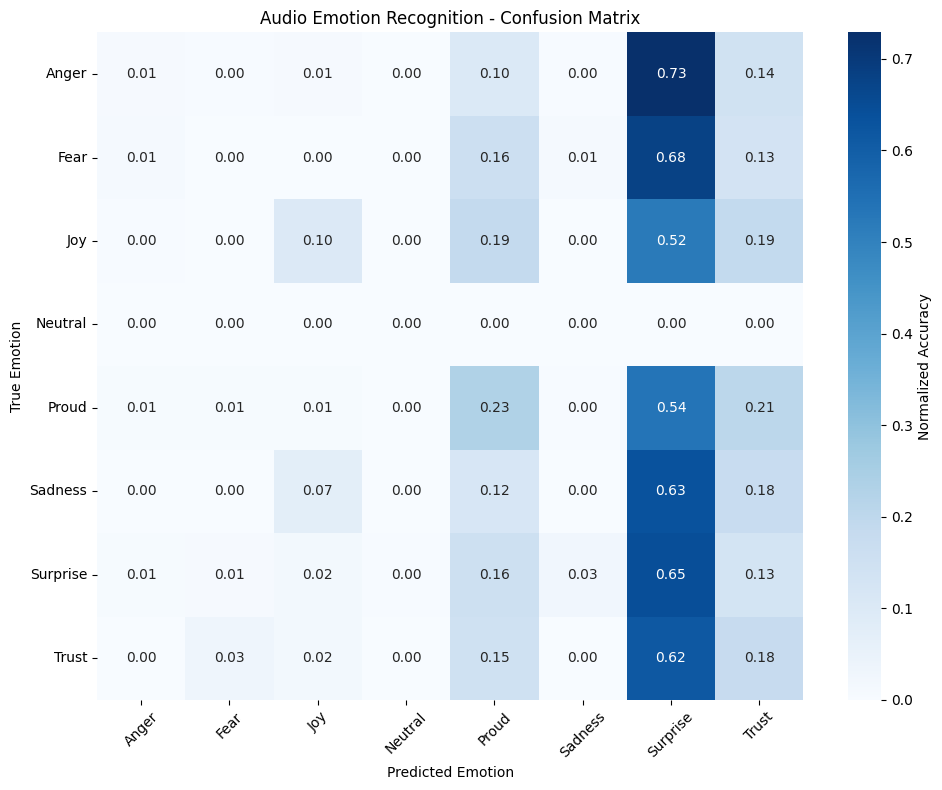


💾 Saving model to D:/Satria_Data/models/specialists/audio...
✅ Model saved successfully!
  📁 Model: xgboost_audio_specialist.json
  📁 Scaler: feature_scaler.pkl
  📁 Info: model_info.json
  📁 Feature Importance: feature_importance.npy

🎮 Testing inference with sample...
True emotion: Surprise
Predicted: Surprise (confidence: 0.645)
All probabilities: {'Anger': 0.012037809, 'Fear': 0.0032245284, 'Joy': 0.014855051, 'Neutral': 0.00018712261, 'Proud': 0.14531758, 'Sadness': 0.0008150801, 'Surprise': 0.64483774, 'Trust': 0.1787251}

🎉 XGBoost Audio Specialist Training Complete!
📈 Final Validation F1-Score: 0.1439


In [54]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# =======================
# 1. Load Audio Features
# =======================
print("🎵 Loading Audio Features...")
X_train = np.load("D:/Satria_Data/models/specialists/audio/X_train_raw.npy")
y_train = np.load("D:/Satria_Data/models/specialists/audio/y_train.npy")
X_val = np.load("D:/Satria_Data/models/specialists/audio/X_val_raw.npy")
y_val = np.load("D:/Satria_Data/models/specialists/audio/y_val.npy")

# Load label mapping
with open("artifacts/label2idx.json") as f:
    label2idx = json.load(f)
idx2label = {v: k for k, v in label2idx.items()}

print(f"📊 Dataset Info:")
print(f"Training: {X_train.shape} features, {y_train.shape} labels")
print(f"Validation: {X_val.shape} features, {y_val.shape} labels")
print(f"Features: {X_train.shape[1]} audio dimensions")
print(f"Classes: {list(idx2label.values())}")

# =======================
# 2. Data Preprocessing for Audio
# =======================
print("\n🔧 Preprocessing Audio Features...")

# Clean any NaN/Inf values (audio-specific)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

# Standardize features (important for audio features with different scales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"✅ Scaled features range: {X_train_scaled.min():.3f} to {X_train_scaled.max():.3f}")

# =======================
# 3. Class Balance Analysis
# =======================
print("\n📊 Class Distribution:")
class_counts = Counter(y_train)
total_samples = len(y_train)
n_classes = len(class_counts)

for class_id, count in class_counts.items():
    emotion = idx2label[class_id]
    percentage = (count / total_samples) * 100
    print(f"  {emotion}: {count} samples ({percentage:.1f}%)")

# Compute class weights for imbalanced audio emotions
class_weight = {cls: total_samples / (n_classes * cnt) for cls, cnt in class_counts.items()}
sample_weights_train = np.array([class_weight[label] for label in y_train])
sample_weights_val = np.array([class_weight[label] for label in y_val])

print(f"\n⚖️ Class Weights (for imbalance):")
for cls, weight in class_weight.items():
    print(f"  {idx2label[cls]}: {weight:.3f}")

# =======================
# 4. Optimized XGBoost for Audio Features
# =======================
print("\n🚀 Training XGBoost Audio Specialist...")

# Audio-optimized parameters
clf = xgb.XGBClassifier(
    # Core settings for multi-class emotion
    objective="multi:softprob",
    num_class=len(label2idx),
    eval_metric="mlogloss",
    
    # Optimized for 106 audio features
    learning_rate=0.08,          # Slightly higher for audio features
    max_depth=10,                # Deeper for complex audio patterns
    n_estimators=500,            # More trees for audio complexity
    
    # Regularization for audio overfitting
    subsample=0.85,              # Higher sampling for audio stability
    colsample_bytree=0.9,        # Most audio features are relevant
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=1.5,              # L2 regularization (stronger for audio)
    
    # Audio-specific optimizations
    min_child_weight=3,          # Prevent overfitting on rare emotions
    gamma=0.1,                   # Minimum split loss
    max_delta_step=1,            # Helps with imbalanced emotions
    
    # Performance
    n_jobs=-1,                   # Use all CPU cores
    random_state=42,
    verbosity=1
)

# Train with sample weights and validation monitoring
print("Training with early stopping...")
clf.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=50                   # Print every 50 rounds
)

# =======================
# 5. Comprehensive Evaluation
# =======================
print("\n📊 Model Evaluation...")

# Predictions
y_pred_train = clf.predict(X_train_scaled)
y_pred_val = clf.predict(X_val_scaled)
y_pred_proba_val = clf.predict_proba(X_val_scaled)

# Metrics
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_val = f1_score(y_val, y_pred_val, average='macro')

print(f"🎯 Training F1-Score: {f1_train:.4f}")
print(f"🎯 Validation F1-Score: {f1_val:.4f}")
print(f"🎯 Overfitting Check: {f1_train - f1_val:.4f} (lower is better)")

# Detailed classification report
print(f"\n📋 Validation Classification Report:")
target_names = [idx2label[i] for i in range(len(idx2label))]
print(classification_report(y_val, y_pred_val, target_names=target_names))

# =======================
# 6. Feature Importance Analysis
# =======================
print(f"\n🔍 Top 15 Most Important Audio Features:")
feature_importance = clf.feature_importances_
top_features = np.argsort(feature_importance)[-15:][::-1]

# Audio feature names mapping
feature_names = (
    ['ZCR', 'RMSE', 'Tempo'] +                           # Time domain (3)
    ['SpectralCentroid', 'SpectralBW', 'SpectralContrast', 'Rolloff', 'SpectralFlatness'] +  # Spectral (5)
    [f'MFCC_mean_{i}' for i in range(20)] +              # MFCC mean (20)
    [f'MFCC_std_{i}' for i in range(20)] +               # MFCC std (20)
    [f'MFCC_delta_{i}' for i in range(20)] +             # MFCC delta (20)
    [f'Chroma_mean_{i}' for i in range(12)] +            # Chroma mean (12)
    [f'Chroma_std_{i}' for i in range(12)] +             # Chroma std (12)
    [f'Tonnetz_mean_{i}' for i in range(6)] +            # Tonnetz mean (6)
    [f'Tonnetz_std_{i}' for i in range(6)] +             # Tonnetz std (6)
    ['Poly_1', 'Poly_2']                                 # Polynomial (2)
)

for i, feat_idx in enumerate(top_features):
    feat_name = feature_names[feat_idx] if feat_idx < len(feature_names) else f"Feature_{feat_idx}"
    print(f"  {i+1:2d}. {feat_name}: {feature_importance[feat_idx]:.4f}")

# =======================
# 7. Confusion Matrix Visualization
# =======================
print(f"\n📈 Generating Confusion Matrix...")
cm = confusion_matrix(y_val, y_pred_val, normalize="true")

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    xticklabels=target_names, 
    yticklabels=target_names, 
    cmap="Blues", 
    fmt=".2f",
    cbar_kws={'label': 'Normalized Accuracy'}
)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Audio Emotion Recognition - Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =======================
# 8. Save Model and Results
# =======================
output_dir = "D:/Satria_Data/models/specialists/audio"
print(f"\n💾 Saving model to {output_dir}...")

# Save XGBoost model
clf.save_model(f"{output_dir}/xgboost_audio_specialist.json")

# Save preprocessing
joblib.dump(scaler, f"{output_dir}/feature_scaler.pkl")

# Save feature importance
np.save(f"{output_dir}/feature_importance.npy", feature_importance)

# Save model metadata
model_info = {
    'model_type': 'XGBoost_Audio_Specialist',
    'feature_dim': 106,
    'num_classes': len(label2idx),
    'f1_train': float(f1_train),
    'f1_validation': float(f1_val),
    'label2idx': label2idx,
    'idx2label': idx2label,
    'class_weights': {int(k): float(v) for k, v in class_weight.items()},
    'feature_names': feature_names[:106],
    'best_iteration': clf.best_iteration if hasattr(clf, 'best_iteration') else len(clf.feature_importances_),
    'model_params': clf.get_params()
}

with open(f"{output_dir}/model_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Model saved successfully!")
print(f"  📁 Model: xgboost_audio_specialist.json")
print(f"  📁 Scaler: feature_scaler.pkl") 
print(f"  📁 Info: model_info.json")
print(f"  📁 Feature Importance: feature_importance.npy")

# =======================
# 9. Quick Inference Test
# =======================
def predict_emotion(audio_features):
    """Quick inference function"""
    # Preprocess
    audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)
    audio_scaled = scaler.transform(audio_features.reshape(1, -1))
    
    # Predict
    pred = clf.predict(audio_scaled)[0]
    proba = clf.predict_proba(audio_scaled)[0]
    
    emotion = idx2label[pred]
    confidence = proba[pred]
    
    return {
        'emotion': emotion,
        'confidence': confidence,
        'all_probabilities': {idx2label[i]: prob for i, prob in enumerate(proba)}
    }

# Test with first validation sample
print(f"\n🎮 Testing inference with sample...")
test_result = predict_emotion(X_val[0])
true_emotion = idx2label[y_val[0]]

print(f"True emotion: {true_emotion}")
print(f"Predicted: {test_result['emotion']} (confidence: {test_result['confidence']:.3f})")
print(f"All probabilities: {test_result['all_probabilities']}")

print(f"\n🎉 XGBoost Audio Specialist Training Complete!")
print(f"📈 Final Validation F1-Score: {f1_val:.4f}")

🎵 Loading Audio Features...
Shape X_train: (69778, 106)
Shape y_train: (69778,)
Shape X_val: (12180, 106)
Shape y_val: (12180,)
Class counts (train): Counter({6: 28465, 7: 15923, 4: 14708, 2: 4691, 0: 3576, 1: 1075, 5: 1028, 3: 312})

🔧 Enhanced feature preprocessing...
🎯 Adding feature engineering...
Original features: 106
Enhanced features: 136

📊 Classes: ['Anger', 'Fear', 'Joy', 'Neutral', 'Proud', 'Sadness', 'Surprise', 'Trust']
Number of classes: 8

⚖️ Computing enhanced class weights...
Enhanced Class Weights: {'Anger': 2.439107941834452, 'Fear': 8.113720930232558, 'Joy': 1.8593583457684928, 'Neutral': 10.0, 'Proud': 0.5930276040250204, 'Sadness': 8.484678988326849, 'Surprise': 0.3064201651150536, 'Trust': 0.5477768008541104}
Using device: cuda

🚀 Training Improved Audio MLP Classifier...
Model parameters: 842,328

📈 Starting advanced training...
Epoch   1/100 | Train Loss: 1.2733 | Train Acc: 13.65% | Val F1: 0.0684 | Val Acc: 0.09% | LR: 0.000976
Epoch  11/100 | Train Loss: 0.

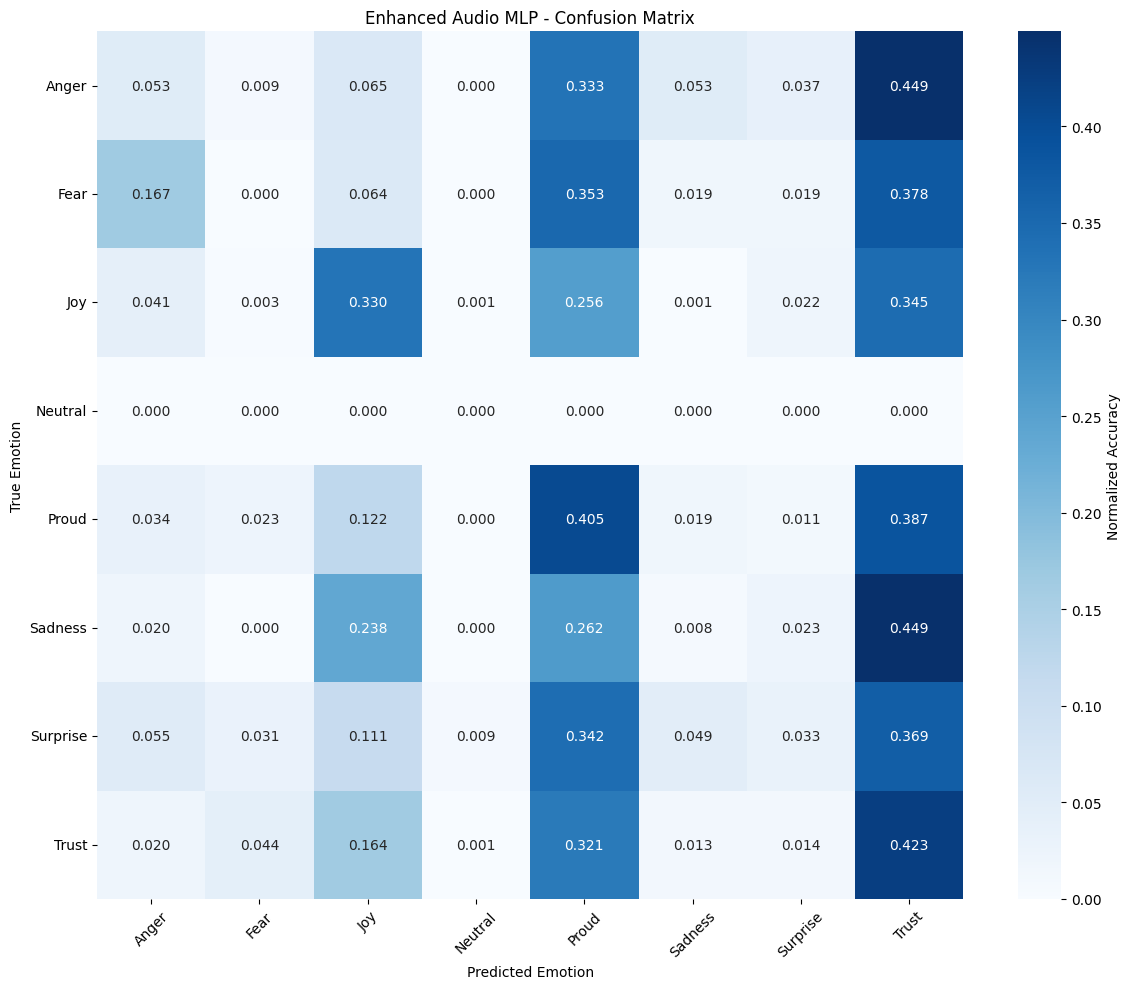

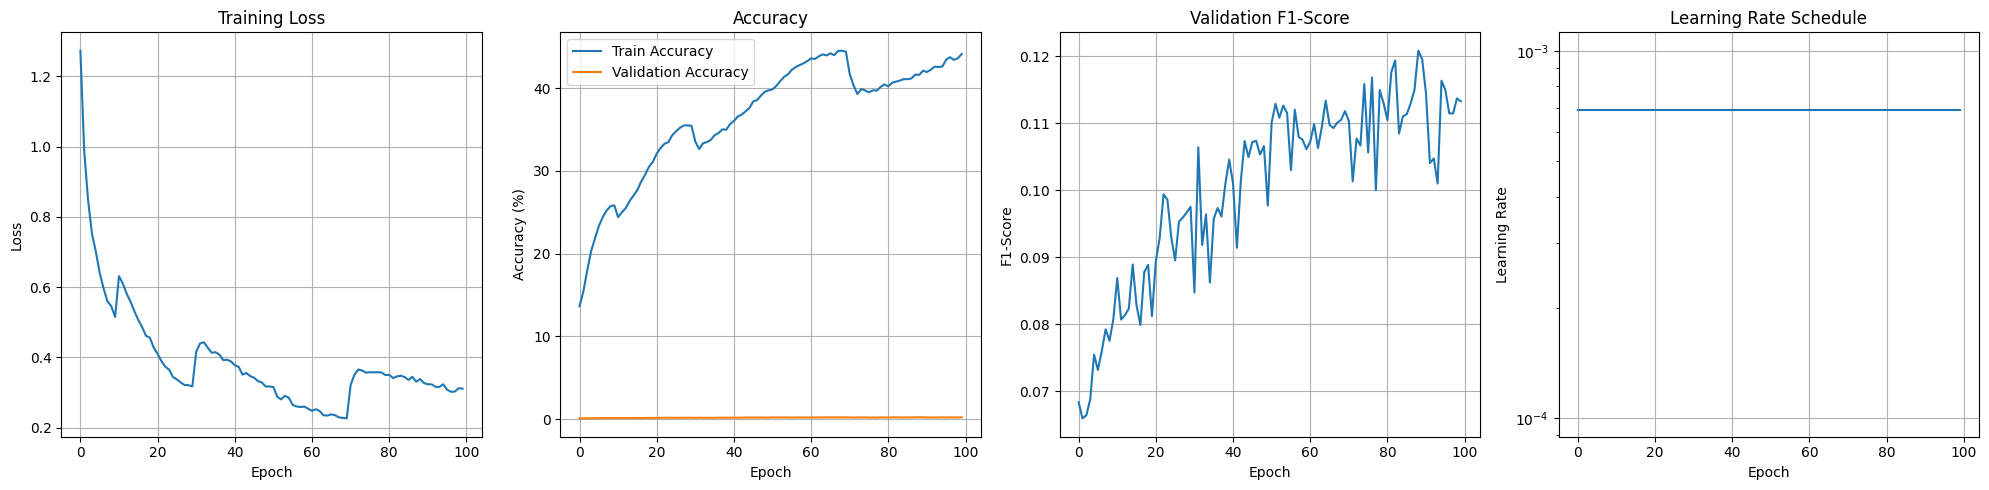


💾 Saving enhanced model to D:/Satria_Data/models/specialists/audio...
✅ Enhanced model saved successfully!
  📁 Model: enhanced_mlp_audio_specialist.pth
  📁 Info: enhanced_mlp_model_info.json

🎮 Testing Enhanced MLP inference...
True emotion: Surprise
Predicted: Trust (confidence: 0.436)

🎉 Enhanced MLP Audio Specialist Training Complete!
📈 Final Validation F1-Score: 0.1208
📈 Final Validation Accuracy: 0.2149
🚀 Improvement techniques applied:
   ✅ Feature Engineering (polynomial + interactions)
   ✅ Deeper Network (5 hidden layers)
   ✅ Focal Loss for imbalanced classes
   ✅ Data Augmentation
   ✅ Gradient Clipping
   ✅ Cosine Annealing LR Schedule
   ✅ Layer-specific Learning Rates


In [71]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os

# =======================
# 1. Load Audio Dataset
# =======================
print("🎵 Loading Audio Features...")
X_train = np.load("D:/Satria_Data/models/specialists/audio/X_train_raw.npy")
y_train = np.load("D:/Satria_Data/models/specialists/audio/y_train.npy")
X_val = np.load("D:/Satria_Data/models/specialists/audio/X_val_raw.npy")
y_val = np.load("D:/Satria_Data/models/specialists/audio/y_val.npy")

# Load label mapping
with open("artifacts/label2idx.json") as f:
    label2idx = json.load(f)
idx2label = {v: k for k, v in label2idx.items()}

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_val:", X_val.shape) 
print("Shape y_val:", y_val.shape)
print("Class counts (train):", Counter(y_train))

# Clean data
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

# =======================
# 2. Enhanced Feature Preprocessing
# =======================
print("\n🔧 Enhanced feature preprocessing...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Add feature engineering (helps with MLP)
print("🎯 Adding feature engineering...")
def add_feature_engineering(X):
    """Add polynomial and interaction features"""
    X_new = X.copy()
    
    # Add squared features for most important features (first 20)
    X_squared = X[:, :20] ** 2
    
    # Add interaction features (first 10 features with next 10)
    X_interaction = X[:, :10] * X[:, 10:20]
    
    # Combine all features
    X_enhanced = np.concatenate([X_new, X_squared, X_interaction], axis=1)
    return X_enhanced

X_train_enhanced = add_feature_engineering(X_train_scaled)
X_val_enhanced = add_feature_engineering(X_val_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Enhanced features: {X_train_enhanced.shape[1]}")

print("\n📊 Classes:", list(idx2label.values()))
print("Number of classes:", len(label2idx))

# =======================
# 3. Improved MLP Model with More Layers
# =======================
class ImprovedAudioMLP(nn.Module):
    def __init__(self, input_dim=136, hidden_dims=[1024, 512, 256, 128, 64], num_classes=8, dropout=0.4):
        super(ImprovedAudioMLP, self).__init__()
        
        self.input_bn = nn.BatchNorm1d(input_dim)  # Input batch norm
        
        layers = []
        prev_dim = input_dim
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        for i, hidden_dim in enumerate(hidden_dims):
            layer = nn.Sequential(
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout if i < len(hidden_dims)-1 else dropout/2)  # Less dropout in final layers
            )
            self.hidden_layers.append(layer)
            prev_dim = hidden_dim
        
        # Output layer
        self.output_layer = nn.Linear(prev_dim, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Input normalization
        x = self.input_bn(x)
        
        # Forward through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)
        
        # Output
        x = self.output_layer(x)
        return x

# =======================
# 4. Advanced Class Weights with Focal Loss
# =======================
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

print("\n⚖️ Computing enhanced class weights...")
class_counts = Counter(y_train)
total = sum(class_counts.values())
n_classes = len(class_counts)

# Enhanced class weights with smoothing
class_weights = []
for i in range(n_classes):
    if i in class_counts:
        # Apply smoothing to extreme weights
        weight = total / (n_classes * class_counts[i])
        weight = min(weight, 10.0)  # Cap maximum weight
        class_weights.append(weight)
    else:
        class_weights.append(1.0)

print("Enhanced Class Weights:", {idx2label[i]: weight for i, weight in enumerate(class_weights)})

# Convert to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train_enhanced)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_enhanced)
y_val_tensor = torch.LongTensor(y_val)

# Create datasets and loaders with data augmentation
class AudioDatasetAugmented(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        
        if self.augment and np.random.random() > 0.5:
            # Add gaussian noise
            noise = np.random.normal(0, 0.01, x.shape)
            x = x + noise
            
            # Random feature dropout
            if np.random.random() > 0.8:
                mask = np.random.random(x.shape) > 0.1
                x = x * mask
        
        return torch.FloatTensor(x), torch.LongTensor([y])

train_dataset = AudioDatasetAugmented(X_train_enhanced, y_train, augment=True)
val_dataset = AudioDatasetAugmented(X_val_enhanced, y_val, augment=False)

batch_size = 32  # Smaller batch size for better gradients
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# =======================
# 5. Advanced Training Setup
# =======================
print("\n🚀 Training Improved Audio MLP Classifier...")

# Model configuration with more parameters
model = ImprovedAudioMLP(
    input_dim=X_train_enhanced.shape[1],
    hidden_dims=[1024, 512, 256, 128, 64],  # Deeper network
    num_classes=len(label2idx),
    dropout=0.4
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Advanced loss function
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = FocalLoss(alpha=1, gamma=2, weight=class_weights_tensor)

# Advanced optimizer with different learning rates
optimizer = optim.AdamW([
    {'params': model.hidden_layers.parameters(), 'lr': 0.001},
    {'params': model.output_layer.parameters(), 'lr': 0.0005},
    {'params': model.input_bn.parameters(), 'lr': 0.0001}
], weight_decay=0.01)

# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# =======================
# 6. Advanced Training Loop with Validation
# =======================
def train_epoch_advanced(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.squeeze().to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()
    
    return total_loss / len(train_loader), 100. * correct / total

def validate_epoch_advanced(model, val_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.squeeze().to(device)
            outputs = model(batch_x)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    f1 = f1_score(all_targets, all_preds, average='macro')
    accuracy = sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    
    return f1, accuracy, all_preds, all_targets

# Training with advanced techniques
print("\n📈 Starting advanced training...")
num_epochs = 100  # More epochs
best_f1 = 0.0
patience_counter = 0
patience = 15  # More patience

train_losses = []
train_accs = []
val_f1s = []
val_accs = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch_advanced(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_f1, val_acc, val_preds, val_targets = validate_epoch_advanced(model, val_loader, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_f1s.append(val_f1)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step()
    
    # Print every 10 epochs
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val F1: {val_f1:.4f} | Val Acc: {val_acc:.2f}% | LR: {current_lr:.6f}")
    
    # Early stopping with F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_predictions = val_preds.copy()
        best_targets = val_targets.copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

print(f"\n🎯 Best Validation F1-Score: {best_f1:.4f}")

# =======================
# 7. Final Evaluation
# =======================
print("\n📊 Final Model Evaluation...")

# Get final predictions
final_f1, final_acc, final_preds, final_targets = validate_epoch_advanced(model, val_loader, device)

print(f"🎯 Final Validation F1-Score: {final_f1:.4f}")
print(f"🎯 Final Validation Accuracy: {final_acc:.4f}")

# Classification Report
print("\n📋 Validation Classification Report:")
target_names = [idx2label[i] for i in range(len(idx2label))]
print(classification_report(final_targets, final_preds, target_names=target_names))

# =======================
# 8. Enhanced Visualization
# =======================
print("\n📈 Generating Enhanced Visualizations...")

# Confusion Matrix
cm = confusion_matrix(final_targets, final_preds, normalize="true")
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    xticklabels=target_names, 
    yticklabels=target_names, 
    cmap="Blues", 
    fmt=".3f",
    cbar_kws={'label': 'Normalized Accuracy'}
)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Enhanced Audio MLP - Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Training curves
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(val_f1s)
plt.title('Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.grid(True)

plt.subplot(1, 4, 4)
# Learning rate plot
lrs = [scheduler.get_last_lr()[0] for _ in range(len(train_losses))]
plt.plot(lrs)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# =======================
# 9. Save Enhanced Model
# =======================
output_dir = "D:/Satria_Data/models/specialists/audio"
os.makedirs(output_dir, exist_ok=True)

print(f"\n💾 Saving enhanced model to {output_dir}...")

# Save enhanced scaler that handles feature engineering
class EnhancedScaler:
    def __init__(self, base_scaler):
        self.base_scaler = base_scaler
    
    def transform(self, X):
        X_scaled = self.base_scaler.transform(X)
        return add_feature_engineering(X_scaled)

enhanced_scaler = EnhancedScaler(scaler)

# Save PyTorch model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': X_train_enhanced.shape[1],
        'hidden_dims': [1024, 512, 256, 128, 64],
        'num_classes': len(label2idx),
        'dropout': 0.4
    },
    'base_scaler': scaler,
    'enhanced_scaler': enhanced_scaler,
    'label2idx': label2idx,
    'idx2label': idx2label,
    'best_f1': float(best_f1),
    'class_weights': class_weights
}, f"{output_dir}/enhanced_mlp_audio_specialist.pth")

# Save model info
model_info = {
    'model_type': 'Enhanced_MLP_Audio_Specialist',
    'base_feature_dim': 106,
    'enhanced_feature_dim': X_train_enhanced.shape[1],
    'num_classes': len(label2idx),
    'hidden_dims': [1024, 512, 256, 128, 64],
    'dropout': 0.4,
    'f1_validation': float(best_f1),
    'accuracy_validation': float(final_acc),
    'label2idx': label2idx,
    'idx2label': idx2label,
    'class_weights': class_weights,
    'training_epochs': epoch + 1,
    'early_stopped': patience_counter >= patience,
    'enhancements': [
        'Feature Engineering (polynomial + interactions)',
        'Deeper Network (5 hidden layers)',
        'Focal Loss for imbalanced classes',
        'Data Augmentation',
        'Gradient Clipping',
        'Cosine Annealing LR Schedule',
        'Layer-specific Learning Rates'
    ]
}

with open(f"{output_dir}/enhanced_mlp_model_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Enhanced model saved successfully!")
print(f"  📁 Model: enhanced_mlp_audio_specialist.pth")
print(f"  📁 Info: enhanced_mlp_model_info.json")

# =======================
# 10. Enhanced Inference Function
# =======================
def predict_emotion_enhanced(audio_features, model=model, enhanced_scaler=enhanced_scaler, device=device):
    """Enhanced MLP inference function"""
    model.eval()
    
    # Preprocess with feature engineering
    audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)
    audio_enhanced = enhanced_scaler.transform(audio_features.reshape(1, -1))
    audio_tensor = torch.FloatTensor(audio_enhanced).to(device)
    
    with torch.no_grad():
        outputs = model(audio_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        probs = probabilities.cpu().numpy()[0]
    
    emotion = idx2label[pred]
    confidence = probs[pred]
    
    return {
        'emotion': emotion,
        'confidence': float(confidence),
        'all_probabilities': {idx2label[i]: float(prob) for i, prob in enumerate(probs)}
    }

# Test with validation sample
print(f"\n🎮 Testing Enhanced MLP inference...")
test_result = predict_emotion_enhanced(X_val[0])
true_emotion = idx2label[y_val[0]]

print(f"True emotion: {true_emotion}")
print(f"Predicted: {test_result['emotion']} (confidence: {test_result['confidence']:.3f})")

print(f"\n🎉 Enhanced MLP Audio Specialist Training Complete!")
print(f"📈 Final Validation F1-Score: {best_f1:.4f}")
print(f"📈 Final Validation Accuracy: {final_acc:.4f}")
print(f"🚀 Improvement techniques applied:")
for enhancement in model_info['enhancements']:
    print(f"   ✅ {enhancement}")

🎵 Loading Audio Features...
Shape X_train: (69778, 106)
Shape y_train: (69778,)
Shape X_val: (12180, 106)
Shape y_val: (12180,)
Class counts (train): Counter({6: 28465, 7: 15923, 4: 14708, 2: 4691, 0: 3576, 1: 1075, 5: 1028, 3: 312})

🔧 Standardizing audio features...

📊 Classes: ['Anger', 'Fear', 'Joy', 'Neutral', 'Proud', 'Sadness', 'Surprise', 'Trust']
Number of classes: 8

⚖️ Computing class weights...
Class Weights: {'Anger': 2.439107941834452, 'Fear': 8.113720930232558, 'Joy': 1.8593583457684928, 'Neutral': 27.955929487179485, 'Proud': 0.5930276040250204, 'Sadness': 8.484678988326849, 'Surprise': 0.3064201651150536, 'Trust': 0.5477768008541104}
Using device: cuda

🚀 Training Audio MLP Classifier...

📈 Starting training...
Epoch  1/50 | Train Loss: 1.8296 | Train Acc: 18.94% | Val F1: 0.0961 | Val Acc: 0.13%
Epoch  6/50 | Train Loss: 1.1330 | Train Acc: 36.06% | Val F1: 0.1169 | Val Acc: 0.19%
Epoch 11/50 | Train Loss: 0.9715 | Train Acc: 42.73% | Val F1: 0.1253 | Val Acc: 0.22%
E

c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


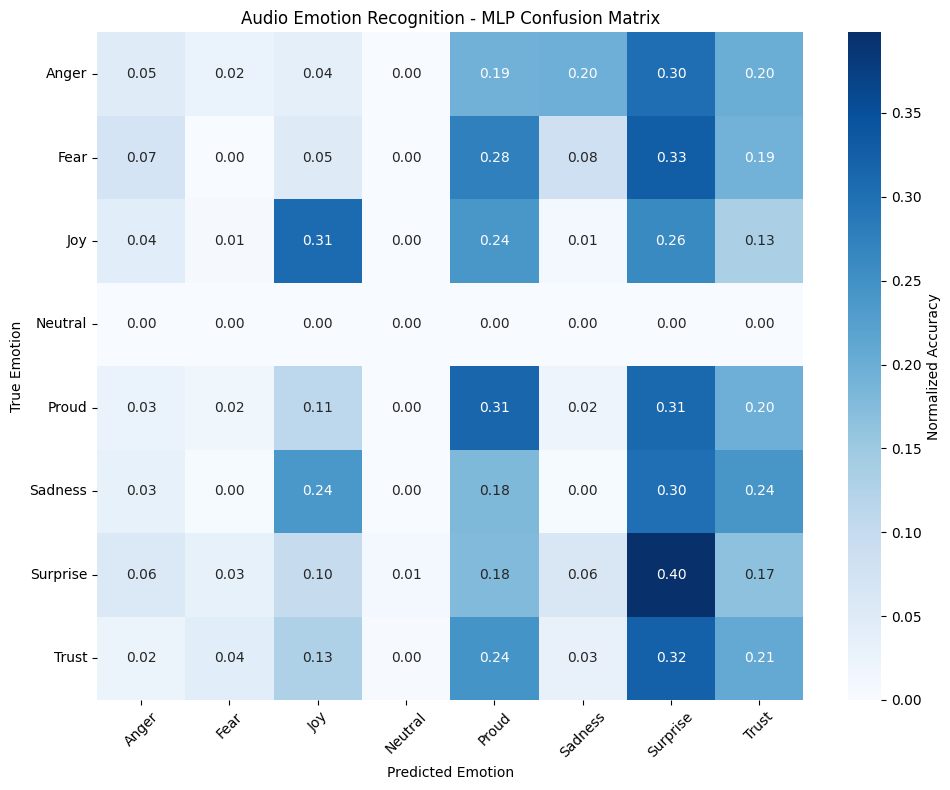

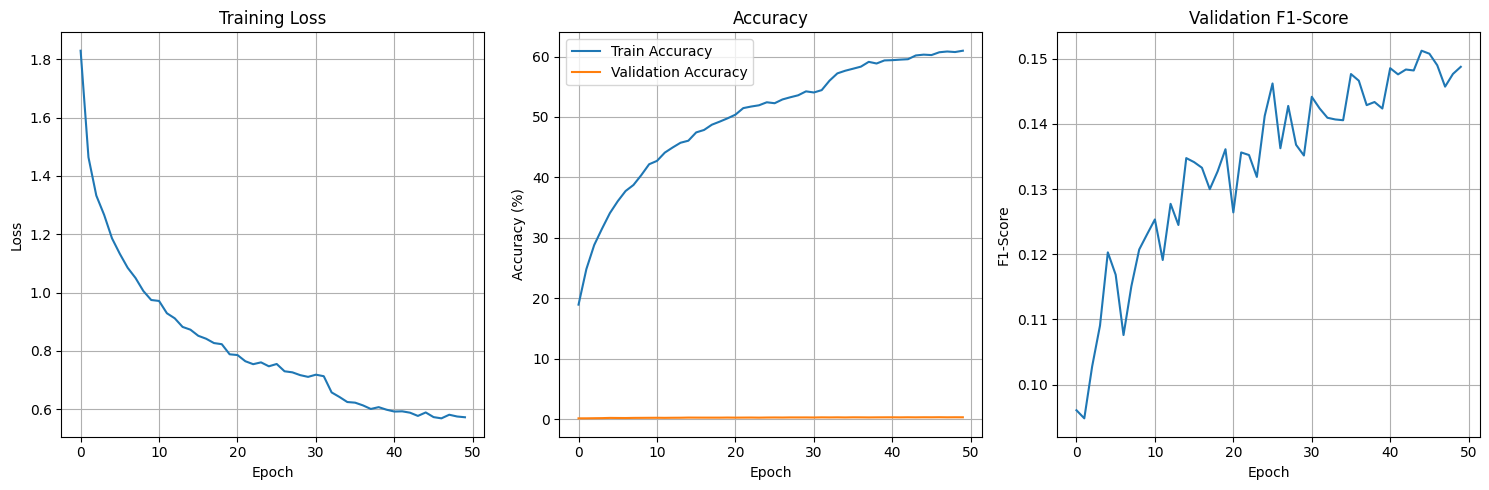


💾 Saving model to D:/Satria_Data/models/specialists/audio...
✅ Model saved successfully!
  📁 Model: mlp_audio_specialist.pth
  📁 Scaler: mlp_feature_scaler.pkl
  📁 Info: mlp_model_info.json

🎮 Testing MLP inference...
True emotion: Surprise
Predicted: Trust (confidence: 0.554)

🎉 MLP Audio Specialist Training Complete!
📈 Final Validation F1-Score: 0.1512
📈 Final Validation Accuracy: 0.3030


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json # oalah okey
import os

# =======================
# 1. Load Audio Dataset
# =======================
print("🎵 Loading Audio Features...")
X_train = np.load("D:/Satria_Data/models/specialists/audio/X_train_raw.npy")
y_train = np.load("D:/Satria_Data/models/specialists/audio/y_train.npy")
X_val = np.load("D:/Satria_Data/models/specialists/audio/X_val_raw.npy")
y_val = np.load("D:/Satria_Data/models/specialists/audio/y_val.npy")

# Load label mapping
with open("artifacts/label2idx.json") as f:
    label2idx = json.load(f)
idx2label = {v: k for k, v in label2idx.items()}

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_val:", X_val.shape) 
print("Shape y_val:", y_val.shape)
print("Class counts (train):", Counter(y_train))

# Clean data
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

# =======================
# 2. Standardize Features
# =======================
print("\n🔧 Standardizing audio features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\n📊 Classes:", list(idx2label.values()))
print("Number of classes:", len(label2idx))

# =======================
# 3. MLP Model Definition
# =======================
class AudioMLP(nn.Module):
    def __init__(self, input_dim=106, hidden_dims=[512, 256, 128], num_classes=8, dropout=0.3):
        super(AudioMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Hidden layers
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)

# =======================
# 4. Prepare Data Loaders with Class Weights
# =======================
print("\n⚖️ Computing class weights...")
class_counts = Counter(y_train)
total = sum(class_counts.values())
n_classes = len(class_counts)

# Compute class weights
class_weights = []
for i in range(n_classes):
    if i in class_counts:
        weight = total / (n_classes * class_counts[i])
        class_weights.append(weight)
    else:
        class_weights.append(1.0)

print("Class Weights:", {idx2label[i]: weight for i, weight in enumerate(class_weights)})

# Convert to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# =======================
# 5. Initialize Model and Training
# =======================
print("\n🚀 Training Audio MLP Classifier...")

# Model configuration
model = AudioMLP(
    input_dim=106,
    hidden_dims=[512, 256, 128],  # 3 hidden layers
    num_classes=len(label2idx),
    dropout=0.3
).to(device)

# Loss function with class weights
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler (no verbose)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5,
)

# =======================
# 6. Training Loop
# =======================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()
    
    return total_loss / len(train_loader), 100. * correct / total

def validate_epoch(model, val_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    f1 = f1_score(all_targets, all_preds, average='macro')
    accuracy = sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    
    return f1, accuracy, all_preds, all_targets

# Training
print("\n📈 Starting training...")
num_epochs = 50
best_f1 = 0.0
patience_counter = 0
patience = 10

train_losses = []
train_accs = []
val_f1s = []
val_accs = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_f1, val_acc, val_preds, val_targets = validate_epoch(model, val_loader, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_f1s.append(val_f1)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_f1)
    
    # Print every 5 epochs
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:2d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val F1: {val_f1:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_predictions = val_preds.copy()
        best_targets = val_targets.copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_state)

print(f"\n🎯 Best Validation F1-Score: {best_f1:.4f}")

# =======================
# 7. Final Evaluation
# =======================
print("\n📊 Final Model Evaluation...")

# Get final predictions
final_f1, final_acc, final_preds, final_targets = validate_epoch(model, val_loader, device)

print(f"🎯 Final Validation F1-Score: {final_f1:.4f}")
print(f"🎯 Final Validation Accuracy: {final_acc:.4f}")

# Classification Report
print("\n📋 Validation Classification Report:")
target_names = [idx2label[i] for i in range(len(idx2label))]
print(classification_report(final_targets, final_preds, target_names=target_names))

# =======================
# 8. Confusion Matrix Visualization
# =======================
print("\n📈 Generating Confusion Matrix...")
cm = confusion_matrix(final_targets, final_preds, normalize="true")
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    xticklabels=target_names, 
    yticklabels=target_names, 
    cmap="Blues", 
    fmt=".2f",
    cbar_kws={'label': 'Normalized Accuracy'}
)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Audio Emotion Recognition - MLP Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =======================
# 9. Training Curves
# =======================
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_f1s)
plt.title('Validation F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# =======================
# 10. Save Model
# =======================
output_dir = "D:/Satria_Data/models/specialists/audio"
os.makedirs(output_dir, exist_ok=True)

print(f"\n💾 Saving model to {output_dir}...")

# Save PyTorch model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': {
        'input_dim': 106,
        'hidden_dims': [512, 256, 128],
        'num_classes': len(label2idx),
        'dropout': 0.3
    },
    'scaler': scaler,
    'label2idx': label2idx,
    'idx2label': idx2label,
    'best_f1': float(best_f1),
    'class_weights': class_weights
}, f"{output_dir}/mlp_audio_specialist.pth")

# Save scaler separately
joblib.dump(scaler, f"{output_dir}/mlp_feature_scaler.pkl")

# Save model info
model_info = {
    'model_type': 'MLP_Audio_Specialist',
    'feature_dim': 106,
    'num_classes': len(label2idx),
    'hidden_dims': [512, 256, 128],
    'dropout': 0.3,
    'f1_validation': float(best_f1),
    'accuracy_validation': float(final_acc),
    'label2idx': label2idx,
    'idx2label': idx2label,
    'class_weights': class_weights,
    'training_epochs': epoch + 1,
    'early_stopped': patience_counter >= patience
}

with open(f"{output_dir}/mlp_model_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Model saved successfully!")
print(f"  📁 Model: mlp_audio_specialist.pth")
print(f"  📁 Scaler: mlp_feature_scaler.pkl")
print(f"  📁 Info: mlp_model_info.json")

# =======================
# 11. Inference Function
# =======================
def predict_emotion_mlp(audio_features, model=model, scaler=scaler, device=device):
    """MLP inference function"""
    model.eval()
    
    # Preprocess
    audio_features = np.nan_to_num(audio_features, nan=0.0, posinf=0.0, neginf=0.0)
    audio_scaled = scaler.transform(audio_features.reshape(1, -1))
    audio_tensor = torch.FloatTensor(audio_scaled).to(device)
    
    with torch.no_grad():
        outputs = model(audio_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        pred = outputs.argmax(dim=1).cpu().numpy()[0]
        probs = probabilities.cpu().numpy()[0]
    
    emotion = idx2label[pred]
    confidence = probs[pred]
    
    return {
        'emotion': emotion,
        'confidence': float(confidence),
        'all_probabilities': {idx2label[i]: float(prob) for i, prob in enumerate(probs)}
    }

# Test with validation sample
print(f"\n🎮 Testing MLP inference...")
test_result = predict_emotion_mlp(X_val[0])
true_emotion = idx2label[y_val[0]]

print(f"True emotion: {true_emotion}")
print(f"Predicted: {test_result['emotion']} (confidence: {test_result['confidence']:.3f})")

print(f"\n🎉 MLP Audio Specialist Training Complete!")
print(f"📈 Final Validation F1-Score: {best_f1:.4f}")
print(f"📈 Final Validation Accuracy: {final_acc:.4f}")